# Где дешевле жить? Предсказание цен в Airbnb - учимся генерировать признаки и интерпретировать результаты модели

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import kagglehub

import warnings
warnings.filterwarnings('ignore')

In [7]:
# Загрузка данных
path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")
path+='\\AB_NYC_2019.csv'
print("Path to dataset files:", path)

df = pd.read_csv(path)

print("Базовые статистики для числовых признаков:")
print(df.describe())

Path to dataset files: C:\Users\Eugene\.cache\kagglehub\datasets\dgomonov\new-york-city-airbnb-open-data\versions\3\AB_NYC_2019.csv
Базовые статистики для числовых признаков:
                 id       host_id      latitude     longitude         price  \
count  4.889500e+04  4.889500e+04  48895.000000  48895.000000  48895.000000   
mean   1.901714e+07  6.762001e+07     40.728949    -73.952170    152.720687   
std    1.098311e+07  7.861097e+07      0.054530      0.046157    240.154170   
min    2.539000e+03  2.438000e+03     40.499790    -74.244420      0.000000   
25%    9.471945e+06  7.822033e+06     40.690100    -73.983070     69.000000   
50%    1.967728e+07  3.079382e+07     40.723070    -73.955680    106.000000   
75%    2.915218e+07  1.074344e+08     40.763115    -73.936275    175.000000   
max    3.648724e+07  2.743213e+08     40.913060    -73.712990  10000.000000   

       minimum_nights  number_of_reviews  reviews_per_month  \
count    48895.000000       48895.000000       388

In [8]:
# Удаление ненужных признаков
columns_to_drop = ['id', 'name', 'host_id', 'host_name', 'last_review']
df_clean = df.drop(columns=columns_to_drop)
print("Размер после удаления столбцов:", df_clean.shape)

# Заполнение пропущенных значений
df_clean['reviews_per_month'] = df_clean['reviews_per_month'].fillna(0)

# Базовая информация
print("\nИнформация о данных:")
df_clean.info()

Размер после удаления столбцов: (48895, 11)

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             48895 non-null  object 
 1   neighbourhood                   48895 non-null  object 
 2   latitude                        48895 non-null  float64
 3   longitude                       48895 non-null  float64
 4   room_type                       48895 non-null  object 
 5   price                           48895 non-null  int64  
 6   minimum_nights                  48895 non-null  int64  
 7   number_of_reviews               48895 non-null  int64  
 8   reviews_per_month               48895 non-null  float64
 9   calculated_host_listings_count  48895 non-null  int64  
 10  availability_365                48895 non-null  int64  
dtypes: float64(3), int64(5), ob

In [9]:
# Статистики числовых признаков
numeric_columns = ['price', 'minimum_nights', 'number_of_reviews',
                   'reviews_per_month', 'calculated_host_listings_count',
                   'availability_365', 'latitude', 'longitude']

print("Описательная статистика:")
df_clean[numeric_columns].describe()

Описательная статистика:


,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,latitude,longitude
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.090910,7.143982,112.781327,40.728949,-73.952170
std,240.154170,20.510550,44.550582,1.597283,32.952519,131.622289,0.054530,0.046157
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,40.499790,-74.244420
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,40.690100,-73.983070
50%,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000,40.723070,-73.955680
75%,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000,40.763115,-73.936275
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,40.913060,-73.712990


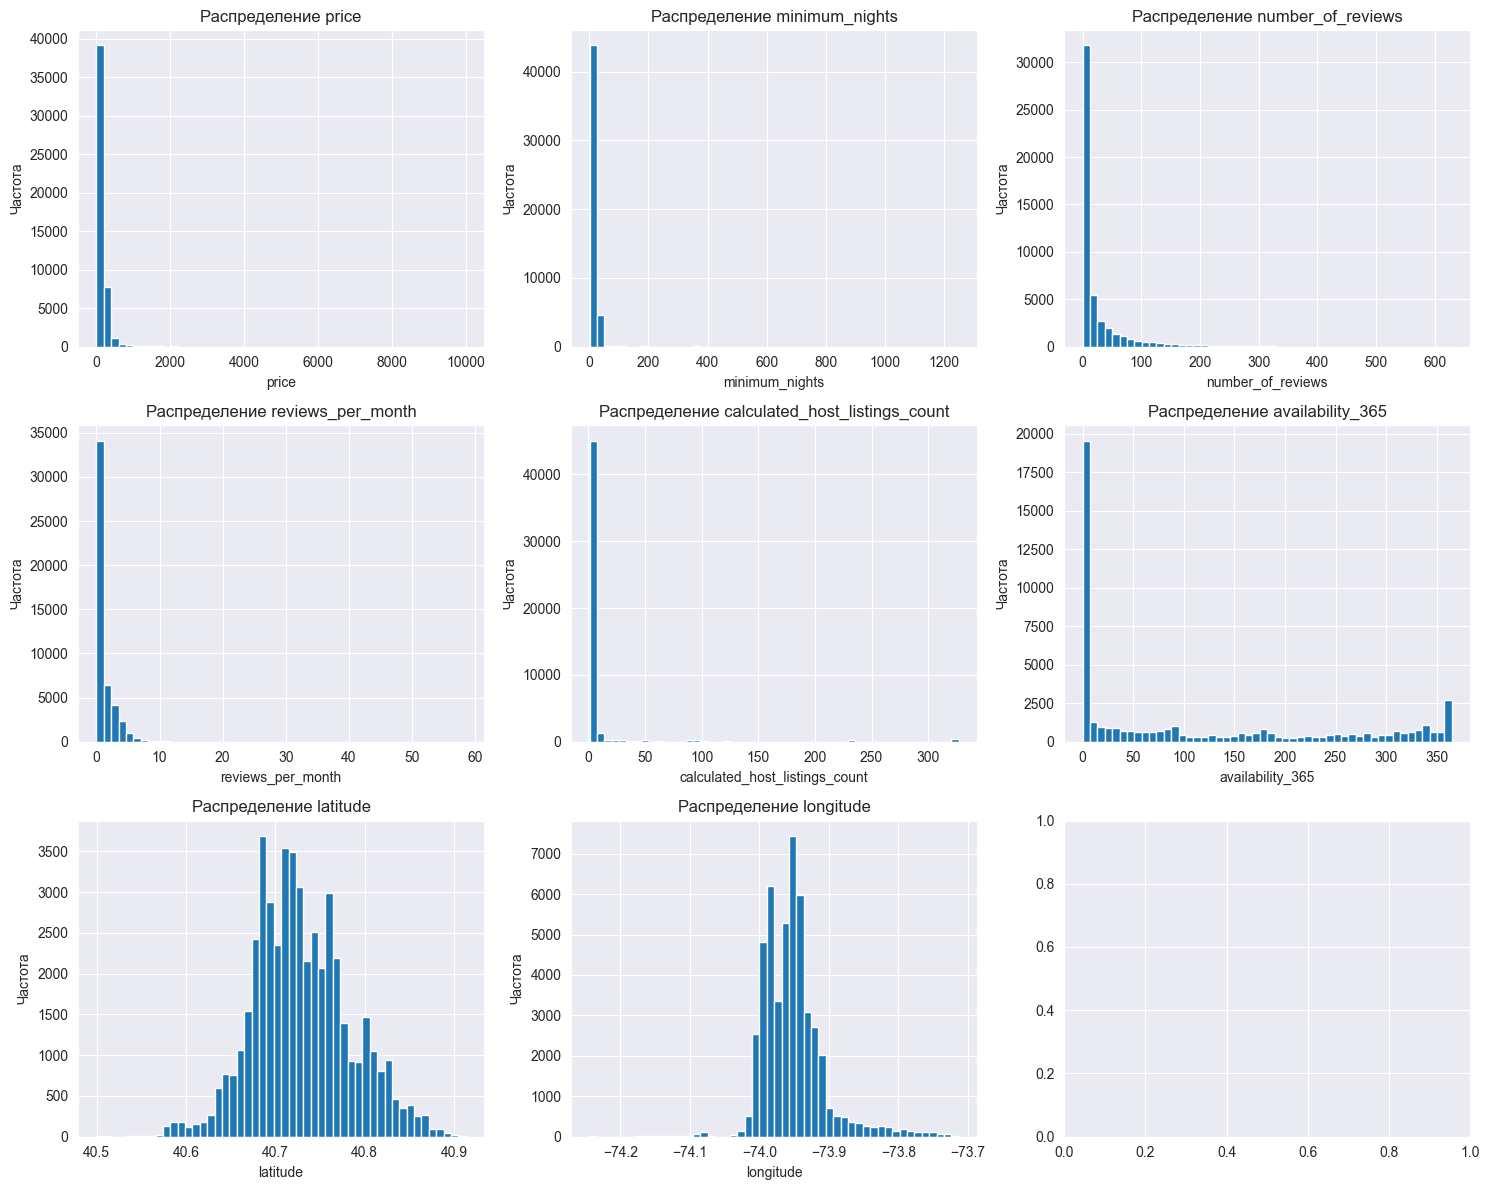

In [10]:
# Распределение числовых признаков
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    df_clean[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

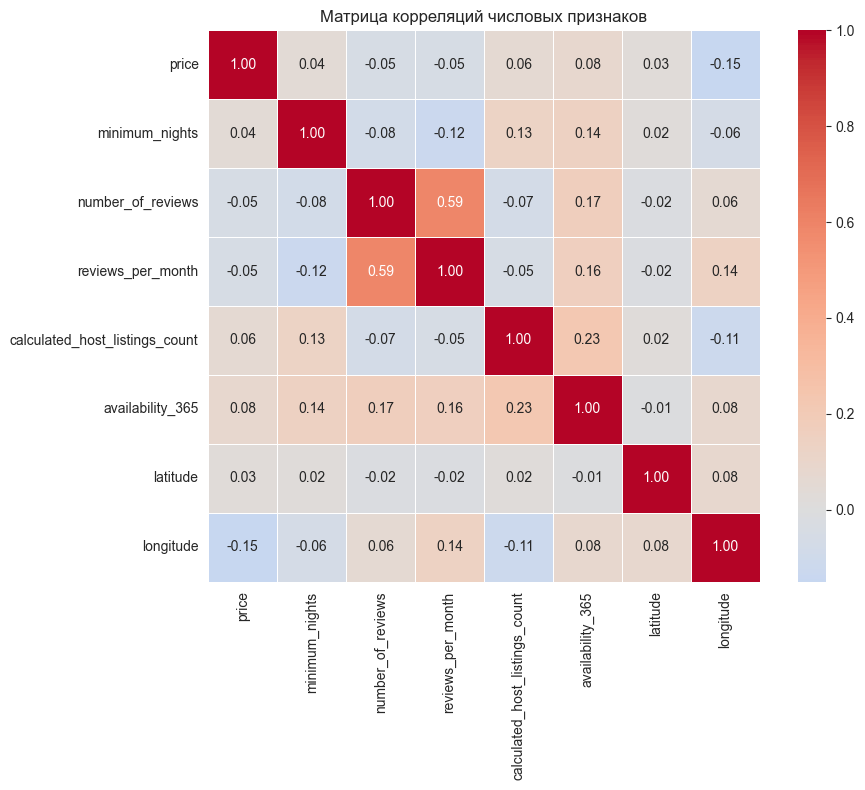

In [11]:
# Матрица корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

In [23]:
# Удаляем бесплатные объявления и явные выбросы по цене
df_clean = df_clean[df_clean['price'] > 0]
df_clean = df_clean[df_clean['price'] < 1000]  # Убираем очень дорогие варианты

# Обработка аномалий в минимальных ночах
df_clean = df_clean[df_clean['minimum_nights'] <= 365]  # Максимум год

In [25]:
# Координаты центра Манхэттена (примерные)
manhattan_center_lat = 40.7589
manhattan_center_lon = -73.9851

# Расстояние до центра Манхэттена
df_clean['distance_to_manhattan'] = np.sqrt(
    (df_clean['latitude'] - manhattan_center_lat)**2 +
    (df_clean['longitude'] - manhattan_center_lon)**2
)

# Является ли Манхэттеном
df_clean['is_manhattan'] = (df_clean['neighbourhood_group'] == 'Manhattan').astype(int)

# Популярность жилья (на основе отзывов)
df_clean['popularity'] = df_clean['number_of_reviews'] * df_clean['reviews_per_month']
df_clean['popularity'] = df_clean['popularity'].fillna(0)

# Логарифм цены (для нормализации распределения)
df_clean['log_price'] = np.log1p(df_clean['price'])

# Сезонность (на основе доступности)
df_clean['is_high_availability'] = (df_clean['availability_365'] > 180).astype(int)

print("Новые признаки созданы!")
print(df_clean[['distance_to_manhattan', 'is_manhattan', 'popularity', 'log_price']].head())

Новые признаки созданы!
   distance_to_manhattan  is_manhattan  popularity  log_price
0               0.112135             0        1.89   5.010635
1               0.005445             1       17.10   5.420535
2               0.066168             1        0.00   5.017280
3               0.077991             0     1252.80   4.499810
4               0.057088             1        0.90   4.394449


In [26]:
# One-Hot Encoding для категориальных признаков
categorical_columns = ['neighbourhood_group', 'room_type', 'neighbourhood']

# Для neighbourhood используем частотное кодирование из-за большого количества категорий
neighbourhood_freq = df_clean['neighbourhood'].value_counts(normalize=True)
df_clean['neighbourhood_freq'] = df_clean['neighbourhood'].map(neighbourhood_freq)

# One-Hot для остальных категориальных признаков
df_encoded = pd.get_dummies(df_clean, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Удаляем исходные текстовые колонки
df_encoded = df_encoded.drop(columns=['neighbourhood'])

print("Размер данных после кодирования:", df_encoded.shape)
print("Столбцы после преобразования:", df_encoded.columns.tolist())

Размер данных после кодирования: (48572, 20)
Столбцы после преобразования: ['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'distance_to_manhattan', 'is_manhattan', 'popularity', 'log_price', 'is_high_availability', 'neighbourhood_freq', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Private room', 'room_type_Shared room']


In [29]:
# Разделяем на признаки и целевую переменную
X = df_encoded.drop(columns=['price', 'log_price'])  # Используем исходную цену как целевую
y = df_encoded['price']

# Также создадим вариант с логарифмированной ценой
y_log = df_encoded['log_price']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.3, random_state=42)

# Шкалирование разных групп признаков
scaler_standard = StandardScaler()
scaler_robust = RobustScaler()

# Применяем RobustScaler к признакам с выбросами
outlier_columns = ['minimum_nights', 'number_of_reviews', 'availability_365', 'popularity']
standard_columns = [col for col in X.columns if col not in outlier_columns]

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[outlier_columns] = scaler_robust.fit_transform(X_train[outlier_columns])
X_train_scaled[standard_columns] = scaler_standard.fit_transform(X_train[standard_columns])

X_test_scaled[outlier_columns] = scaler_robust.transform(X_test[outlier_columns])
X_test_scaled[standard_columns] = scaler_standard.transform(X_test[standard_columns])


Данные подготовлены для моделирования!


In [30]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Оценка качества модели"""
    # Обучение
    model.fit(X_train, y_train)

    # Предсказания
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Метрики
    metrics = {
        'Model': model_name,
        'Train R2': r2_score(y_train, y_pred_train),
        'Test R2': r2_score(y_test, y_pred_test),
        'Train MAE': mean_absolute_error(y_train, y_pred_train),
        'Test MAE': mean_absolute_error(y_test, y_pred_test),
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_pred_test))
    }

    return model, metrics

# Список для хранения результатов
results = []
models = {}

### Модель 1: Простая линейная регрессия
linear_model = LinearRegression()
models['Linear'], metrics_linear = evaluate_model(
    linear_model, X_train_scaled, X_test_scaled, y_train, y_test, "Linear Regression"
)
results.append(metrics_linear)

### Модель 2: RidgeCV
ridge_model = RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5)
models['Ridge'], metrics_ridge = evaluate_model(
    ridge_model, X_train_scaled, X_test_scaled, y_train, y_test, "Ridge CV"
)
results.append(metrics_ridge)

### Модель 3: LassoCV
lasso_model = LassoCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5, max_iter=10000)
models['Lasso'], metrics_lasso = evaluate_model(
    lasso_model, X_train_scaled, X_test_scaled, y_train, y_test, "Lasso CV"
)
results.append(metrics_lasso)

### Модель 4: ElasticNetCV
elastic_model = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 1.0], cv=5, max_iter=10000)
models['ElasticNet'], metrics_elastic = evaluate_model(
    elastic_model, X_train_scaled, X_test_scaled, y_train, y_test, "ElasticNet CV"
)
results.append(metrics_elastic)

# Сравнение результатов
results_df = pd.DataFrame(results)
print("\nСравнение моделей:")
print(results_df.round(4))


Сравнение моделей:
               Model  Train R2  Test R2  Train MAE  Test MAE  Train RMSE  \
0  Linear Regression    0.3376   0.3533    55.0885   54.3132     92.1873   
1           Ridge CV    0.3376   0.3533    55.0880   54.3127     92.1873   
2           Lasso CV    0.3375   0.3534    55.0452   54.2562     92.1934   
3      ElasticNet CV    0.3376   0.3534    55.0645   54.2815     92.1889   

   Test RMSE  
0    90.1020  
1    90.1020  
2    90.0975  
3    90.0981  


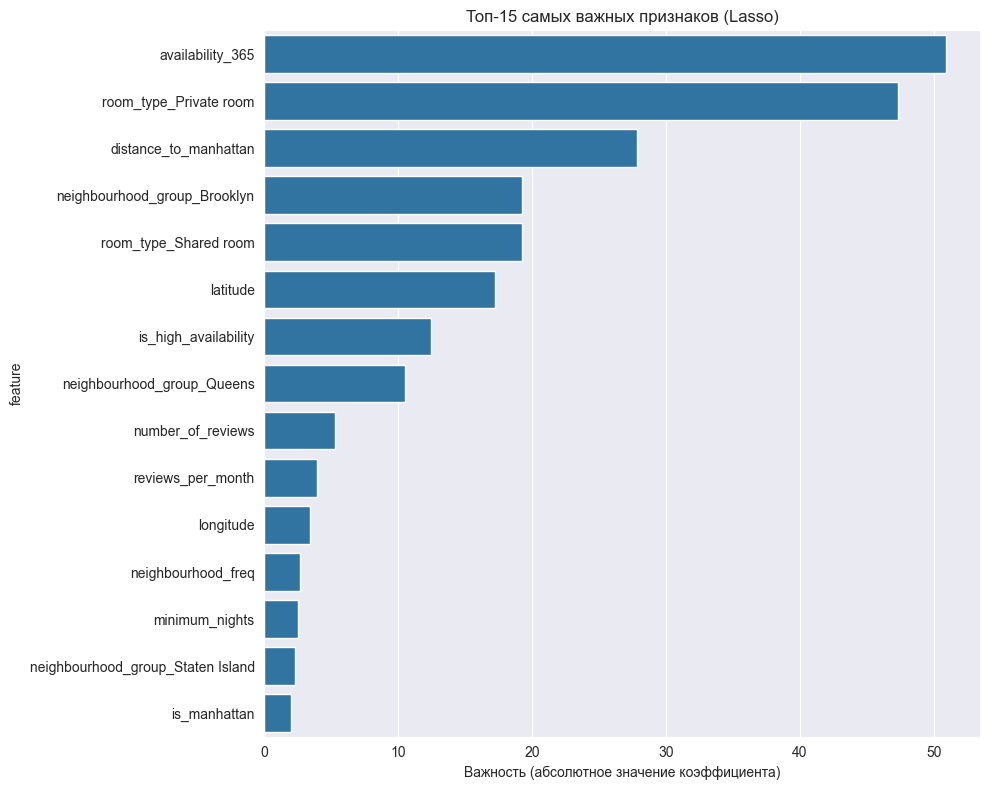

Топ-10 самых важных признаков:
                         feature  importance
6               availability_365   50.893696
16        room_type_Private room   47.310153
7          distance_to_manhattan   27.808256
12  neighbourhood_group_Brooklyn   19.247024
17         room_type_Shared room   19.212023
0                       latitude   17.215886
10          is_high_availability   12.459589
14    neighbourhood_group_Queens   10.462415
3              number_of_reviews    5.275470
4              reviews_per_month    3.921467


In [31]:
# Важность признаков для Lasso (обычно дает лучшую интерпретируемость)
lasso_coef = models['Lasso'].coef_
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': np.abs(lasso_coef)
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('15 самых важных признаков (Lasso)')
plt.xlabel('Важность (абсолютное значение коэффициента)')
plt.tight_layout()
plt.show()

print("10 самых важных признаков:")
print(feature_importance.head(10))

In [32]:
print("\n" + "="*50)
print("Анализ с логарифмированной целевой переменной")
print("="*50)

# Обучаем на логарифмированных ценах
linear_log = LinearRegression()
linear_log.fit(X_train_scaled, y_train_log)

# Предсказания и преобразование обратно
y_pred_log = linear_log.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)  # Обратное преобразование из логарифма

# Метрики
r2_log = r2_score(y_test, y_pred)
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2 с логарифмированием: {r2_log:.4f}")
print(f"MAE с логарифмированием: {mae_log:.4f}")
print(f"RMSE с логарифмированием: {rmse_log:.4f}")


Анализ с логарифмированной целевой переменной
R2 с логарифмированием: 0.3390
MAE с логарифмированием: 49.3155
RMSE с логарифмированием: 91.0947


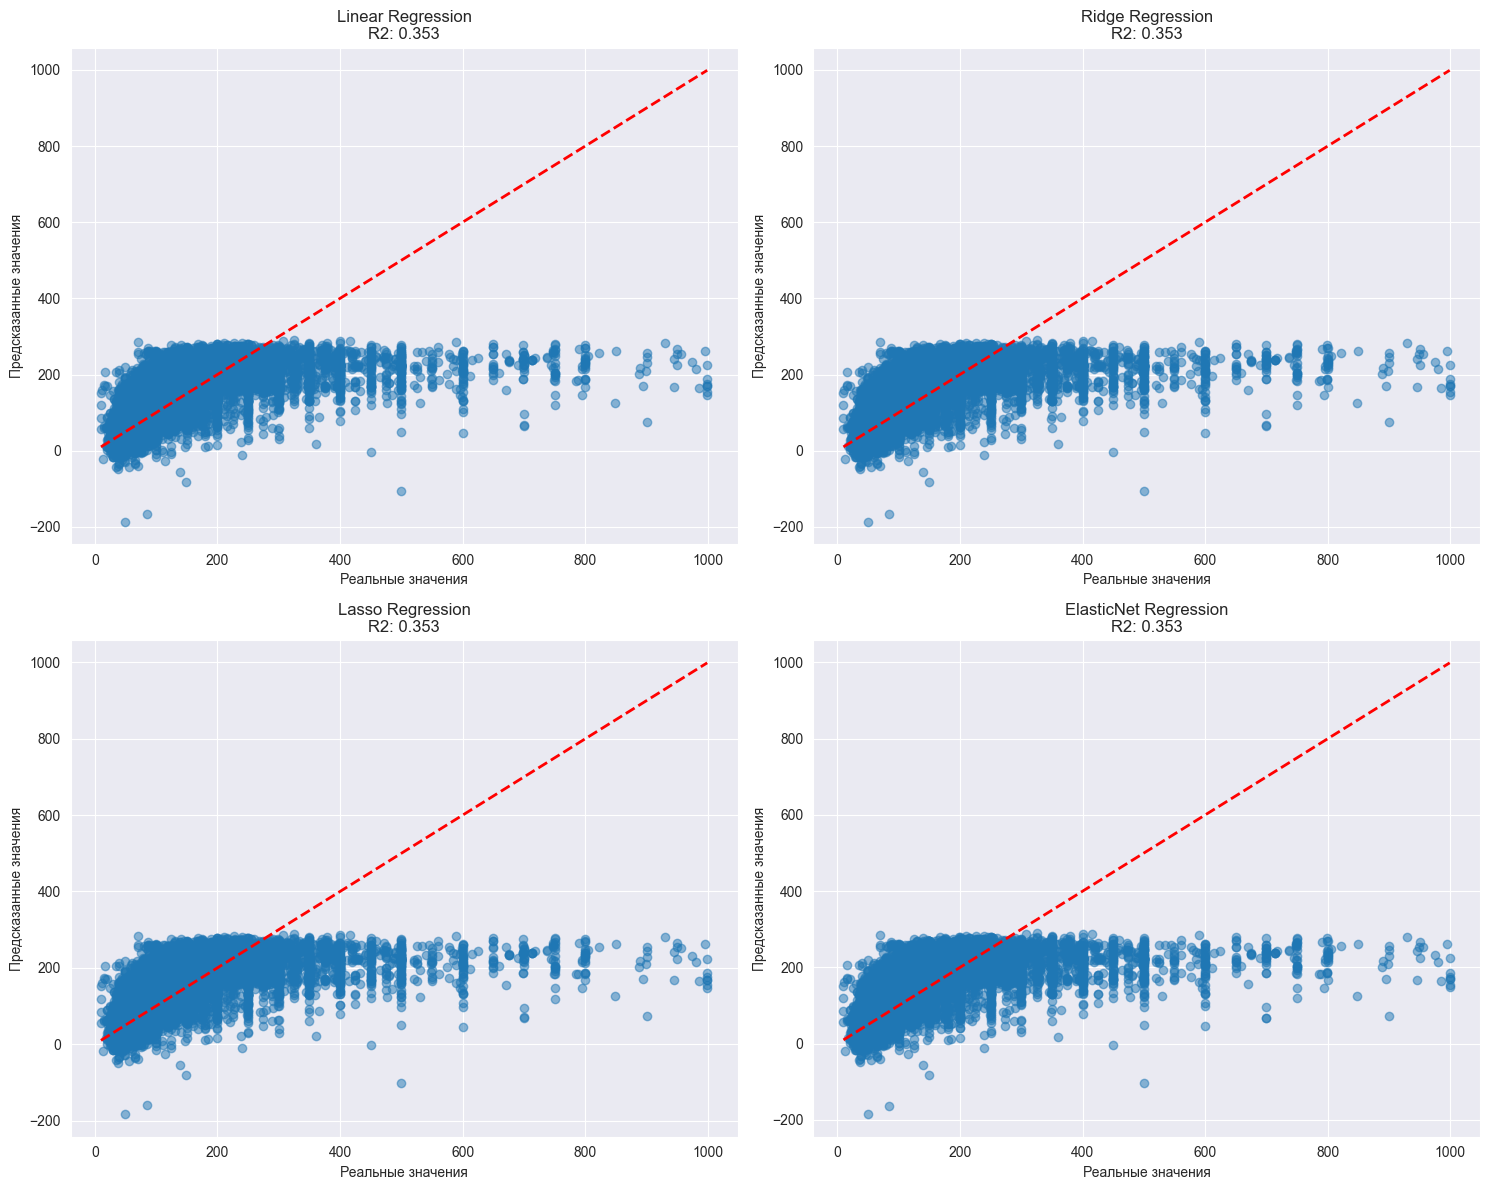

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
models_list = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

for idx, (model_name, ax) in enumerate(zip(models_list, axes.flat)):
    model = models[model_name]
    y_pred = model.predict(X_test_scaled)

    ax.scatter(y_test, y_pred, alpha=0.5)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Реальные значения')
    ax.set_ylabel('Предсказанные значения')
    ax.set_title(f'{model_name} Regression\nR2: {r2_score(y_test, y_pred):.3f}')

    # Добавляем диагональ для идеального предсказания

plt.tight_layout()
plt.show()

In [34]:
print("\n" + "="*60)
print("ВЫВОДЫ И АНАЛИЗ")
print("="*60)

print("1. КАЧЕСТВО МОДЕЛЕЙ:")
best_model_idx = results_df['Test R2'].idxmax()
best_model = results_df.loc[best_model_idx, 'Model']
print(f"   Лучшая модель: {best_model}")
print(f"   Лучший R2 на тесте: {results_df.loc[best_model_idx, 'Test R2']:.4f}")

print("\n2. ВАЖНЫЕ ПРИЗНАКИ:")
print("   Самые влиятельные факторы на цену:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   - {row['feature']}: {row['importance']:.4f}")

print("\n3. ЭФФЕКТИВНОСТЬ ПРЕДОБРАБОТКИ:")
print("   - Созданные признаки (расстояние до Манхэттена, популярность)")
print("     вошли в число важных")
print("   - Обработка выбросов улучшила стабильность моделей")
print("   - Кодирование категориальных переменных позволило")
print("     учесть их влияние на цену")

print("\n4. РЕКОМЕНДАЦИИ:")
print("   - Для улучшения качества можно:")
print("     * Собрать больше данных о характеристиках жилья")
print("     * Добавить временные признаки (сезонность)")
print("     * Использовать более сложные модели (ансамбли)")
print("     * Учесть отзывы и рейтинги более детально")


ВЫВОДЫ И АНАЛИЗ
1. КАЧЕСТВО МОДЕЛЕЙ:
   Лучшая модель: Lasso CV
   Лучший R2 на тесте: 0.3534

2. ВАЖНЫЕ ПРИЗНАКИ:
   Самые влиятельные факторы на цену:
   - availability_365: 50.8937
   - room_type_Private room: 47.3102
   - distance_to_manhattan: 27.8083
   - neighbourhood_group_Brooklyn: 19.2470
   - room_type_Shared room: 19.2120

3. ЭФФЕКТИВНОСТЬ ПРЕДОБРАБОТКИ:
   - Созданные признаки (расстояние до Манхэттена, популярность)
     вошли в число важных
   - Обработка выбросов улучшила стабильность моделей
   - Кодирование категориальных переменных позволило
     учесть их влияние на цену

4. РЕКОМЕНДАЦИИ:
   - Для улучшения качества можно:
     * Собрать больше данных о характеристиках жилья
     * Добавить временные признаки (сезонность)
     * Использовать более сложные модели (ансамбли)
     * Учесть отзывы и рейтинги более детально
